<a href="https://colab.research.google.com/github/ldsbalu/Balu-Portfolio/blob/main/LLM_Text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Preparing DataSet




In [1]:
!pip install --upgrade transformers


In [3]:
import pandas as pd
import torch
from datasets import Dataset as HFDataset
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    Trainer,
    TrainingArguments,
    pipeline
)

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu126


In [ ]:
# print("Loading dataset...")
# dataset = load_dataset("sms_spam", "plain_text")
# print("Dataset loaded successfully!")

In [6]:

print("Loading dataset...")
try:
  df = pd.read_csv("iphone.csv")
except FileNotFoundError:
    print("ERROR: iphone.csv not found. Check you file if its uploaded or not")
    raise

# 2. Remove any rows with missing prompts or completions
df.dropna(subset=['prompt', 'completion'], inplace=True)

# 3. Convert the cleaned DataFrame into a Dataset object
print("Converting to Hugging Face Dataset...")
dataset_hf = HFDataset.from_pandas(df)


print("Dataset loaded successfully!")

Loading dataset...
Converting to Hugging Face Dataset...
Dataset loaded successfully!


In [7]:
train_test_split = dataset_hf.train_test_split(test_size=0.2, seed=42)
train_dataset_hf = train_test_split['train']
val_dataset_hf = train_test_split['test']



In [8]:
print(f"Training set size: {len(train_dataset_hf)}")
print(f"Validation set size: {len(val_dataset_hf)}")
print("\nSample from training data:")
print(train_dataset_hf[0])

Training set size: 171
Validation set size: 43

Sample from training data:
{'prompt': "What is 'Reachability'?", 'completion': 'Reachability is a feature that makes it easier to use larger iPhones with one hand. Swipe down on the bottom edge of the screen to bring the top half of the display down into easy reach of your thumb.'}


creating Data loaders


In [9]:
class PromptCompletionDataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=256):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
      example = self.dataset[index]
      prompt = str(example["prompt"])
      completion = str(example["completion"])
      combined_text = prompt + self.tokenizer.eos_token + completion
      encodings = self.tokenizer(
          combined_text,
          truncation=True,
          padding="max_length",
          max_length=self.max_length,
          return_tensors="pt"
      )
      input_ids = encodings["input_ids"].squeeze(0)
      attention_mask = encodings["attention_mask"].squeeze(0)
      labels = input_ids.clone()
      return {
          "input_ids": input_ids,
          "attention_mask": attention_mask,
          "labels": labels
      }



In [10]:
model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

train_dataset_torch = PromptCompletionDataset(
    hf_dataset=train_dataset_hf,
    tokenizer=tokenizer,
    max_length=256
)

validation_dataset_torch = PromptCompletionDataset(
    hf_dataset=val_dataset_hf,
    tokenizer=tokenizer,
    max_length=256
)

print(f"Max length for tokenization is: {train_dataset_torch.max_length}")
print(f"Number of training samples: {len(train_dataset_torch)}")
print(f"Number of validation samples: {len(validation_dataset_torch)}")



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Max length for tokenization is: 256
Number of training samples: 171
Number of validation samples: 43


In [11]:
print("Example item from training set:")
print(train_dataset_torch[0])


Example item from training set:
{'input_ids': tensor([ 2061,   318,   705,  3041,   620,  1799, 30960, 50256,  3041,   620,
         1799,   318,   257,  3895,   326,  1838,   340,  4577,   284,   779,
         4025, 33845,   351,   530,  1021,    13,  2451,  3757,   866,   319,
          262,  4220,  5743,   286,   262,  3159,   284,  2222,   262,  1353,
         2063,   286,   262,  3359,   866,   656,  2562,  3151,   286,   534,
        15683,    13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 502

In [12]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return {
        "input_ids": torch.stack([item["input_ids"] for item in batch]),
        "attention_mask": torch.stack([item["attention_mask"] for item in batch]),
        "labels": torch.stack([item["labels"] for item in batch])
    }
# Training DataLoader (shuffle for training)
train_loader = DataLoader(
    train_dataset_torch,
    batch_size=8,
    shuffle=True
)

# Validation DataLoader (no shuffle)
val_loader = DataLoader(
    validation_dataset_torch,
    batch_size=8,
    shuffle=False
)



In [13]:
print("Inspecting a batch from the DataLoader:")
for batch in train_loader:
    input_batch = batch["input_ids"]
    target_batch = batch["labels"]

    print("Input batch dimensions:", input_batch.shape)
    print("Label batch dimensions:", target_batch.shape)
    break

Inspecting a batch from the DataLoader:
Input batch dimensions: torch.Size([8, 256])
Label batch dimensions: torch.Size([8, 256])


In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")

22 training batches
6 validation batches


initilizing the model with preptrained models

In [15]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

# model_name = "gpt2"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer.pad_token = tokenizer.eos_token
# model = AutoModelForCausalLM.from_pretrained(model_name)


In [17]:
model_names = [
    "gpt2",
    "distilgpt2",
    "EleutherAI/gpt-neo-125M",
    "microsoft/phi-1_5"
]

models = []
tokenizers = []
for name in model_names:
    tokenizer = AutoTokenizer.from_pretrained(name)
    tokenizer.pad_token = tokenizer.eos_token
    model = AutoModelForCausalLM.from_pretrained(name)
    models.append(model)
    tokenizers.append(tokenizer)
print("All models loaded")

All models loaded


In [18]:
def tokenize_function(examples):
    # Merge prompt and completion with EOS between, capped at max_length
    text = [p + tokenizer.eos_token + c for p, c in zip(examples["prompt"], examples["completion"])]
    result = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=128
    )
    result["labels"] = result["input_ids"].copy()
    return result


In [19]:
tokenized_train = train_dataset_hf.map(tokenize_function, batched=True)
tokenized_val = val_dataset_hf.map(tokenize_function, batched=True)

Map:   0%|          | 0/171 [00:00<?, ? examples/s]

Map:   0%|          | 0/43 [00:00<?, ? examples/s]

In [ ]:
# training_args = TrainingArguments(
#     output_dir="./iphone_results",
#     num_train_epochs=3,
#     per_device_train_batch_size=4,
#     per_device_eval_batch_size=4,
#     logging_steps=10,

# )

In [28]:
# for name, model, tokenizer in zip(model_names, models, tokenizers):
#     training_args = TrainingArguments(
#         output_dir=f"./results/{name}",
#         num_train_epochs=3,
#         per_device_train_batch_size=1,
#         per_device_eval_batch_size=1,
#         gradient_accumulation_steps=2,
#         fp16=True,
#         logging_steps=10,

#     )
#     torch.cuda.empty_cache()

In [25]:
import transformers
print(transformers.__version__)

4.57.1


In [29]:
phi_training_args = TrainingArguments(
    output_dir=f"./results/{name}",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    fp16=True,
    logging_steps=10,
    eval_strategy="epoch", # Use `eval_strategy` for SFTTrainer, Unsloth, etc.
    save_strategy="epoch",
    load_best_model_at_end=True,
)



In [30]:
trainer = Trainer(
    model=model,
    args=phi_training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
)


# 5. Train the model
print("Starting the fine-tuning and evaluation process...")
trainer.train()

# 6. Explicitly evaluate the final best model
final_metrics = trainer.evaluate()
print("\nFinal Evaluation Metrics:")
print(final_metrics)

Starting the fine-tuning and evaluation process...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ldsbalu (ldsbalu-brigham-young-university-hawaii) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.948900,0.964137
2,0.373100,1.057202
3,0.094400,1.202612



Final Evaluation Metrics:
{'eval_loss': 0.964137077331543, 'eval_runtime': 1.8148, 'eval_samples_per_second': 23.694, 'eval_steps_per_second': 23.694, 'epoch': 3.0}


In [31]:

prompt = "How do I manage location services for specific apps?"
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids = input_ids.to(model.device)
attention_mask = torch.ones_like(input_ids)

output = model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_new_tokens=23,
    num_return_sequences=1,
    do_sample=False,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(output[0], skip_special_tokens=True))



How do I manage location services for specific apps?Go to Settings > Privacy & Security > Privacy & Security & Security & Privacy & Security & Privacy & Security &


In [32]:
def report_on_builtin_decoding(prompt, model, tokenizer, device):
    param_sets = [
        {"method": "Greedy", "do_sample": False, "temperature": 1.0, "max_new_tokens": 32},
        {"method": "Top-K (k=50, t=0.7)", "do_sample": True, "temperature": 0.7, "top_k": 50, "max_new_tokens": 32},
        {"method": "Top-P (p=0.95, t=1.2)", "do_sample": True, "temperature": 1.2, "top_p": 0.95, "max_new_tokens": 32}
    ]
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    generations = []
    for params in param_sets:
        # Create a copy of params to avoid modifying the original dict
        gen_params = params.copy()
        # The 'method' key is for our label, not for the generate function
        del gen_params['method']

        output = model.generate(input_ids, pad_token_id=tokenizer.eos_token_id, **gen_params)
        generations.append((params, tokenizer.decode(output[0], skip_special_tokens=True)))
    return generations

In [81]:
device = "cuda" if torch.cuda.is_available() else "cpu"
prompt = "How do I hide a page of apps on my Home Screen?"


for name, base_model, base_tokenizer in zip(model_names, models, tokenizers):
    # If this is the fine-tuned model, use the 'trainer.model' which is the best version
    if name == "microsoft/phi-1_5":
        print(f"\n--- {name} (Fine-Tuned) results: ---")
        m_to_test = trainer.model # Use the best fine-tuned model
        t_to_test = tokenizer
    else:
        print(f"\n--- {name} (Base Model) results: ---")
        m_to_test = base_model
        t_to_test = base_tokenizer

    m_to_test.to(device)
    for params, gen in report_on_builtin_decoding(prompt, m_to_test, t_to_test, device):
        print(f"Method: {params['method']}\nText: {gen}\n")


--- gpt2 (Base Model) results: ---
Method: Greedy
Text: How do I hide a page of apps on my Home Screen?

You can hide a page of apps on your Home Screen by using the Home Screen Lock feature.

How do I hide a page of apps on

Method: Top-K (k=50, t=0.7)
Text: How do I hide a page of apps on my Home Screen?

When your app is showing up in the home screen you should turn on its hiding mode. You can also enable its hiding mode by right-clicking

Method: Top-P (p=0.95, t=1.2)
Text: How do I hide a page of apps on my Home Screen?

You can always hide your apps from Android phones which need to run apps and display information.

You also can always hide apps in your Android Browser


--- distilgpt2 (Base Model) results: ---
Method: Greedy
Text: How do I hide a page of apps on my Home Screen?

































Method: Top-K (k=50, t=0.7)
Text: How do I hide a page of apps on my Home Screen?‬‬‬‬‬‬‬‬‬‬‬‬‬‬‬‬

Method: Top-P (p=0.95, t=1.2)
Text: How do I hide a page of apps on my

Adding Classification
* List item
* List item

In [34]:
print(model) # This prints the structure of the last model, phi-1_5

PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_layernorm): LayerNorm((2048,), eps=1e-

In [ ]:
# def run_generation(prompt, model, tokenizer, device):
#     param_sets = [
#         {"do_sample": False, "temperature": 1.0, "max_new_tokens": 32},
#         {"do_sample": True, "temperature": 0.7, "top_k": 50, "max_new_tokens": 32},
#         {"do_sample": True, "temperature": 1.2, "top_p": 0.95, "max_new_tokens": 32}
#     ]
#     input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
#     generations = []
#     for params in param_sets:
#         output = model.generate(input_ids, pad_token_id=tokenizer.eos_token_id, **params)
#         generations.append((params, tokenizer.decode(output[0], skip_special_tokens=True)))
#     return generations


In [35]:
inputs = tokenizer.encode("Do you have time", return_tensors="pt")  # Already batch format

print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # (batch_size, num_tokens)

# (batch_size, num_tokens, vocab_size)


Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [36]:
with torch.no_grad():
    inputs = inputs.to(model.device)
    outputs = model(inputs)


print("Outputs (object):\n", outputs)
print("Logits tensor dimensions:", outputs.logits.shape)

Outputs (object):
 CausalLMOutputWithPast(loss=None, logits=tensor([[[11.2266,  8.1719,  3.9551,  ...,  1.0098,  1.0098,  1.0098],
         [10.0156,  8.4922,  6.6641,  ...,  2.4648,  2.4648,  2.4648],
         [ 6.6484,  6.2773,  4.4883,  ...,  2.4121,  2.4141,  2.4141],
         [ 9.0938,  8.4766,  6.8984,  ...,  1.3789,  1.3809,  1.3809]]],
       device='cuda:0'), past_key_values=DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer]), hidden_states=None, attentions=None)
Logits tensor dimensions: torch.Size([1, 4, 51200])


In [37]:
print("Last output token:", outputs.logits[:, -1, :])


Last output token: tensor([[9.0938, 8.4766, 6.8984,  ..., 1.3789, 1.3809, 1.3809]],
       device='cuda:0')


In [38]:
logits = outputs.logits
probas = torch.softmax(logits, dim=-1)
label = torch.argmax(probas, dim=-1)

print(label)

tensor([[345, 423, 257, 284]], device='cuda:0')


classification loss and accuracy

In [39]:
# Get logits tensor (batch_size, sequence_length, vocab_size)
logits = outputs.logits

# Get logits for the last token (batch_size, vocab_size)
last_logits = logits[:, -1, :]

# For classification or most likely token prediction
predicted_token_id = torch.argmax(last_logits, dim=-1)  # returns [batch_size] shape

print("Predicted class/token id:", predicted_token_id.item())

# Optionally decode to string token (for text generation tasks)
predicted_token = tokenizer.decode([predicted_token_id.item()])
print("Predicted token (as text):", predicted_token)



Predicted class/token id: 284
Predicted token (as text):  to


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Make sure your model is on the correct device
model.to(device)

Using device: cuda


PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2048)
    (layers): ModuleList(
      (0-23): 24 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear(in_features=2048, out_features=8192, bias=True)
          (fc2): Linear(in_features=8192, out_features=2048, bias=True)
        )
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
      )
    )
    (rotary_emb): PhiRotaryEmbedding()
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (final_layernorm): LayerNorm((2048,), eps=1e-

In [41]:


def calc_accuracy_loader(data_loader, model, device, tokenizer, num_batches=None):
    model.eval()
    correct_predictions = 0
    total_tokens = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    # Make sure pad_token_id is not None before proceeding
    if tokenizer.pad_token_id is None:
        raise ValueError("Tokenizer pad_token_id is not set. Please set `tokenizer.pad_token = tokenizer.eos_token`")

    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break

        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels)
            logits = outputs.logits  # (batch_size, seq_length, vocab_size)

            # Next-token prediction: compare logits at t with label at t+1
            if logits.shape[1] > 1:
                # Exclude last time step to align with shifted labels
                shifted_logits = logits[:, :-1, :]
                shifted_labels = labels[:, 1:]
                shifted_mask = (shifted_labels != tokenizer.pad_token_id)

                preds = torch.argmax(shifted_logits, dim=-1)  # (batch_size, seq_len-1)
                correct_predictions += (preds[shifted_mask] == shifted_labels[shifted_mask]).sum().item()
                total_tokens += shifted_mask.sum().item()
            else:
                # For degenerate case of seq_length=1 (rare), skip
                continue

    return correct_predictions / total_tokens if total_tokens > 0 else 0.0


In [42]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset_torch, batch_size=8, shuffle=True)
val_loader = DataLoader(validation_dataset_torch, batch_size=8, shuffle=False)


In [43]:
print(f"Training accuracy: {calc_accuracy_loader(train_loader, model,device, tokenizer,  num_batches=10) * 100:.2f}%")
print(f"Validation accuracy: {calc_accuracy_loader(val_loader, model,device,tokenizer, num_batches=10) * 100:.2f}%")


Training accuracy: 75.60%
Validation accuracy: 48.98%


In [44]:

import torch.nn.functional as F

def calc_loss_batch(input_batch, model, device, tokenizer):
    model.eval()  # Disable dropout/batchnorm
    input_ids = input_batch['input_ids'].to(device)
    attention_mask = input_batch['attention_mask'].to(device)
    labels = input_batch['labels'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # (batch, seq_len, vocab_size)

        # Shift logits and labels for next-token prediction, exclude last logit/first label
        shift_logits = logits[:, :-1, :].contiguous()      # (batch, seq_len-1, vocab_size)
        shift_labels = labels[:, 1:].contiguous()          # (batch, seq_len-1)
        shift_mask = (shift_labels != tokenizer.pad_token_id)

        # Flatten tensors for cross-entropy: (batch*(seq_len-1), vocab_size) and (batch*(seq_len-1))
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )

        # Mask out pad tokens, average loss over only non-pad tokens
        masked_loss = loss[shift_mask.view(-1)]
        avg_loss = masked_loss.mean() if masked_loss.numel() > 0 else torch.tensor(0.0)

    return avg_loss.item()



In [45]:

def calc_loss_loader(data_loader, model, device, tokenizer, num_batches=None):
    model.eval()
    total_loss = 0.0
    total_tokens = 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits  # (batch, seq_len, vocab_size)

            # Shift logits/labels for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            shift_mask = (shift_labels != tokenizer.pad_token_id)

            # Flatten for cross-entropy: (batch*(seq_len-1), vocab_size), (batch*(seq_len-1))
            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                reduction='none'
            )
            # Only keep loss for non-padding tokens
            masked_loss = loss[shift_mask.view(-1)]
            total_loss += masked_loss.sum().item()
            total_tokens += shift_mask.sum().item()

    mean_loss = total_loss / total_tokens if total_tokens > 0 else 0.0
    return mean_loss


In [46]:
train_loss = calc_loss_loader(train_loader, model, device, tokenizer,num_batches=10)
val_loss = calc_loss_loader(val_loader, model, device, tokenizer,num_batches=10)


print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")



Train Loss: 0.9862
Validation Loss: 2.3054


finetunning model

In [47]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, tokenizer
):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Next-token prediction: shift labels/logits, flatten
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()
            loss = torch.nn.functional.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=tokenizer.pad_token_id
            )
            loss.backward()
            optimizer.step()

            examples_seen += input_ids.size(0)
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss = calc_loss_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
                val_loss = calc_loss_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [48]:
def evaluate_model(model, train_loader, val_loader, device, tokenizer, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, tokenizer, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, tokenizer, num_batches=eval_iter)
    model.train()  # Reset to training mode after evaluating
    return train_loss, val_loss


In [49]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.938, Val loss 2.454
Training accuracy: 89.24% | Validation accuracy: 47.01%
Training accuracy: 95.25% | Validation accuracy: 46.96%
Ep 3 (Step 000050): Train loss 0.184, Val loss 3.180
Training accuracy: 95.94% | Validation accuracy: 48.40%
Training accuracy: 96.30% | Validation accuracy: 48.68%
Ep 5 (Step 000100): Train loss 0.137, Val loss 3.405
Training accuracy: 96.81% | Validation accuracy: 48.91%
Training accuracy: 96.49% | Validation accuracy: 48.49%
Ep 7 (Step 000150): Train loss 0.109, Val loss 3.367
Training accuracy: 96.78% | Validation accuracy: 48.40%
Training accuracy: 96.53% | Validation accuracy: 47.84%
Training accuracy: 96.46% | Validation accuracy: 48.77%
Ep 10 (Step 000200): Train loss 0.102, Val loss 3.378
Training accuracy: 96.89% | Validation accuracy: 48.63%
Training completed in 1.12 minutes.


In [50]:
import matplotlib.pyplot as plt
def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

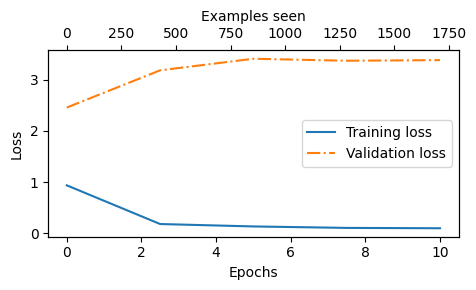

In [51]:
epochs_tensor = torch.linspace(0, 10, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

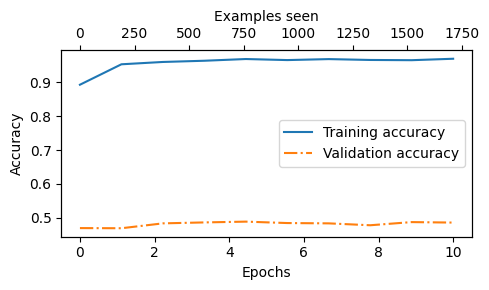

In [52]:
epochs_tensor = torch.linspace(0, 10, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [53]:
train_accuracy = calc_accuracy_loader(train_loader, model, device, tokenizer)
val_accuracy = calc_accuracy_loader(val_loader, model, device, tokenizer)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")

Training accuracy: 96.74%
Validation accuracy: 48.89%


In [82]:
import torch.nn.functional as F

def custom_top_k_generate(model, tokenizer, prompt, max_new_tokens=32, top_k=50, temperature=1.0, device="cuda"):
    model.eval()
    model.to(device)

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    generated_ids = input_ids

    with torch.no_grad():
        for _ in range(max_new_tokens):

            outputs = model(generated_ids)
            next_token_logits = outputs.logits[:, -1, :]


            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature

            top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
            filtered_logits = torch.full_like(next_token_logits, -float('Inf'))
            filtered_logits.scatter_(1, top_k_indices, top_k_logits)
            probabilities = F.softmax(filtered_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

            if next_token_id.item() == tokenizer.eos_token_id:
                break

    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

finetuned_model = trainer.model # Use the best model from the trainer
finetuned_tokenizer = tokenizer

prompt_test = "How do I hide a page of apps on my Home Screen?"
print("--- Testing Custom Top-K Generator ---")
custom_output = custom_top_k_generate(finetuned_model, finetuned_tokenizer, prompt_test, device=device)
print(custom_output)

--- Testing Custom Top-K Generator ---
How do I hide a page of apps on my Home Screen?
Press and hold an empty area on your Home Screen to enter jiggle mode. Tap the dots at the bottom of the screen. In the 'Edit Pages


In [67]:
!pip install evaluate rouge_score bert_score

In [83]:
# Load metrics
import evaluate

print("Loading evaluation metrics...")
try:
    rouge = evaluate.load('rouge')
    bertscore = evaluate.load('bertscore')
    print("Metrics loaded successfully.")
except Exception as e:
    print(f"Error loading metrics: {e}")


# We will use the fine-tuned model (from the Trainer) for this comparison
finetuned_model = trainer.model
finetuned_tokenizer = tokenizer
finetuned_model.to(device)

# Helper function to run generation with parameters
def parameterized_generate(prompt, model, tokenizer, device, **kwargs):
    model.eval()
    encodings = tokenizer(
        prompt,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            **kwargs
        )
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Helper function to clean the output
def clean_generation(prompt, generated_text):
    if generated_text.startswith(prompt):
        return generated_text[len(prompt):].lstrip()
    return generated_text


@torch.no_grad()
def calculate_perplexity(text, model, tokenizer, device="cuda"):
    model.eval()
    if not text: # Handle empty string
        return 0.0
    encodings = tokenizer(text, return_tensors='pt')
    input_ids = encodings.input_ids.to(device)
    target_ids = input_ids.clone()

    if input_ids.shape[1] == 0: # Handle if tokenization is empty
        return 0.0

    outputs = model(input_ids, labels=target_ids)
    loss = outputs.loss
    perplexity = torch.exp(loss)

    return perplexity.item()

print("\n--- Metric setup complete. Ready to run evaluation. ---")

Loading evaluation metrics...
Metrics loaded successfully.

--- Metric setup complete. Ready to run evaluation. ---


In [71]:
# Use a sample of the validation set for speed
val_sample = val_dataset_hf.select(range(10)) # Use 10 examples

results = {
    'builtin_greedy': {'rougeL': [], 'bert_f1': [], 'perplexity': []},
    'builtin_top_k': {'rougeL': [], 'bert_f1': [], 'perplexity': []},
    'custom_top_k': {'rougeL': [], 'bert_f1': [], 'perplexity': []}
}

for i, example in enumerate(val_sample):
    print(f"Evaluating sample {i+1}/{len(val_sample)}...")
    prompt = example['prompt']
    reference_completion = example['completion']
    references = [reference_completion]

    # 1. Built-in Greedy
    builtin_greedy_output = parameterized_generate(prompt, finetuned_model, finetuned_tokenizer, device, max_new_tokens=32, do_sample=False)
    greedy_completion = clean_generation(prompt, builtin_greedy_output)

    # 2. Built-in Top-K
    builtin_top_k_output = parameterized_generate(prompt, finetuned_model, finetuned_tokenizer, device, max_new_tokens=32, do_sample=True, top_k=50, temperature=0.7)
    top_k_completion = clean_generation(prompt, builtin_top_k_output)

    # 3. Custom Top-K
    custom_top_k_output = custom_top_k_generate(finetuned_model, finetuned_tokenizer, prompt, max_new_tokens=32, top_k=50, temperature=0.7, device=device)
    custom_completion = clean_generation(prompt, custom_top_k_output)

    predictions = [greedy_completion, top_k_completion, custom_completion]

    safe_predictions = [p if p else " " for p in predictions]
    safe_references = [r if r else " " for r in references]

    # Calculate Metrics
    try:
        rouge_scores = rouge.compute(predictions=safe_predictions, references=safe_references * 3)
        bert_scores = bertscore.compute(predictions=safe_predictions, references=safe_references * 3, lang='en', model_type="distilbert-base-uncased")

        # Use new function
        perp_greedy = calculate_perplexity(safe_predictions[0], finetuned_model, finetuned_tokenizer, device)
        perp_top_k = calculate_perplexity(safe_predictions[1], finetuned_model, finetuned_tokenizer, device)
        perp_custom = calculate_perplexity(safe_predictions[2], finetuned_model, finetuned_tokenizer, device)

        # Store results
        results['builtin_greedy']['rougeL'].append(rouge_scores['rougeL'])
        results['builtin_top_k']['rougeL'].append(rouge_scores['rougeL'])
        results['custom_top_k']['rougeL'].append(rouge_scores['rougeL'])

        results['builtin_greedy']['bert_f1'].append(bert_scores['f1'][0])
        results['builtin_top_k']['bert_f1'].append(bert_scores['f1'][1])
        results['custom_top_k']['bert_f1'].append(bert_scores['f1'][2])

        results['builtin_greedy']['perplexity'].append(perp_greedy)
        results['builtin_top_k']['perplexity'].append(perp_top_k)
        results['custom_top_k']['perplexity'].append(perp_custom)

    except Exception as e:
        print(f"Skipping example '{prompt}' due to metric error: {e}")
        continue

print("\n--- Average Metric Report (on 10 validation samples) ---")

Evaluating sample 1/10...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Evaluating sample 2/10...
Evaluating sample 3/10...
Evaluating sample 4/10...
Evaluating sample 5/10...
Evaluating sample 6/10...
Evaluating sample 7/10...
Evaluating sample 8/10...
Evaluating sample 9/10...
Evaluating sample 10/10...

--- Average Metric Report (on 10 validation samples) ---


In [72]:
import numpy as np
print("\n** ROUGE-L (Higher is better) **")
print(f"Built-in Greedy: {np.mean(results['builtin_greedy']['rougeL']):.4f}")
print(f"Built-in Top-K:  {np.mean(results['builtin_top_k']['rougeL']):.4f}")
print(f"Custom Top-K:    {np.mean(results['custom_top_k']['rougeL']):.4f}")

print("\n** BERTScore F1 (Higher is better) **")
print(f"Builtin Greedy: {np.mean(results['builtin_greedy']['bert_f1']):.4f}")
print(f"Built-in Top-K: {np.mean(results['builtin_top_k']['bert_f1']):.4f}")
print(f"Custom Top-K:   {np.mean(results['custom_top_k']['bert_f1']):.4f}")

print("\n** Perplexity (Lower is better) **")
print(f"Built-in Greedy: {np.mean(results['builtin_greedy']['perplexity']):.2f}")
print(f"Built-in Top-K:  {np.mean(results['builtin_top_k']['perplexity']):.2f}")
print(f"Custom Top-K:    {np.mean(results['custom_top_k']['perplexity']):.2f}")


** ROUGE-L (Higher is better) **
Built-in Greedy: 0.2333
Built-in Top-K:  0.2333
Custom Top-K:    0.2333

** BERTScore F1 (Higher is better) **
Builtin Greedy: 0.8080
Built-in Top-K: 0.8009
Custom Top-K:   0.8128

** Perplexity (Lower is better) **
Built-in Greedy: 4.04
Built-in Top-K:  4.64
Custom Top-K:    4.22


In [73]:
def generate_text(prompt, model, tokenizer, device, max_length=128, max_new_tokens=32, do_sample=False):
    model.eval()
    # Tokenize prompt and send to device
    encodings = tokenizer(
        prompt,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt"
    )
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    # Model text generation
    with torch.no_grad():
        output_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            pad_token_id=tokenizer.eos_token_id
        )
    # Decode generated text (skip special tokens)
    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return generated_text



In [79]:
prompt = "How do I hide a page of apps on my Home Screen?"
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(prompt)
print(answer)



How do I hide a page of apps on my Home Screen?
Press and hold an empty area on your Home Screen to enter jiggle mode. You can then tap the dots at the bottom of the screen. In the '


In [75]:
prompt = "How do I turn off read receipts in Messages?"
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(answer)

In Messages, go to the 'Recents' tab and tap 'Offload'. The apps will automatically remove the receipts from your personal inbox. You can then


In [80]:
prompt = input()
result = generate_text(
    prompt,
    model, tokenizer, device, max_length=128, max_new_tokens=32
)

# Remove the question found in the start of result
if result.startswith(prompt):
    answer = result[len(prompt):].lstrip()
else:
    answer = result
print(answer)

how take screen shots on my phone 
In the Camera app, open the camera icon and swipe up. You can take photos and videos on your iPhone as you normally would, and the camera will
